# **Resolución de la ecuación del calor bidimensional aplicada a una barra de largo L y ancho L**

## **Importación de librerías y preparación de entorno**

In [1]:
%env DDE_BACKEND=tensorflow.compat.v1
#%env DDE_BACKEND = tensorflow

env: DDE_BACKEND=tensorflow.compat.v1


In [2]:
import numpy as np
import deepxde as dde
from deepxde.backend import tf
from modulePINN import Geometry, IC_BC, loadData, PINN, Ploter, Makegrid

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


## **Definición de parámetros geométricos del problema**

In [3]:
# Condición inicial sinusoidal 2D
def initial_condition(x):
    return 2.0 * np.sin(np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])

In [4]:
params_placa = [0, 1, [0, 0], [1, 1]]
placa = Geometry("placa")
geom_placa, timedomain_placa, geomtime_placa = placa.geometry_domain(params_placa)

In [5]:
icbc = IC_BC(geomtime_placa)
ic_placa, bc_placa = icbc.problem_conditions(0.2, f = lambda x: initial_condition(x))

## **Datos sintéticos y entrenamiento**

In [6]:
def pde2d(x, u):
  a = 0.4

  du_t = dde.grad.jacobian(u, x, i=0, j=1)
  du_xx = dde.grad.hessian(u, x, i=0, j=0)
  du_yy = dde.grad.hessian(u, x, i=1, j=1)

  return du_t - a * (du_xx + du_yy)

In [7]:
data_placa = loadData(pde2d, geomtime_placa, ic_placa, bc_placa).get_data(2000, 150, 300, 600)

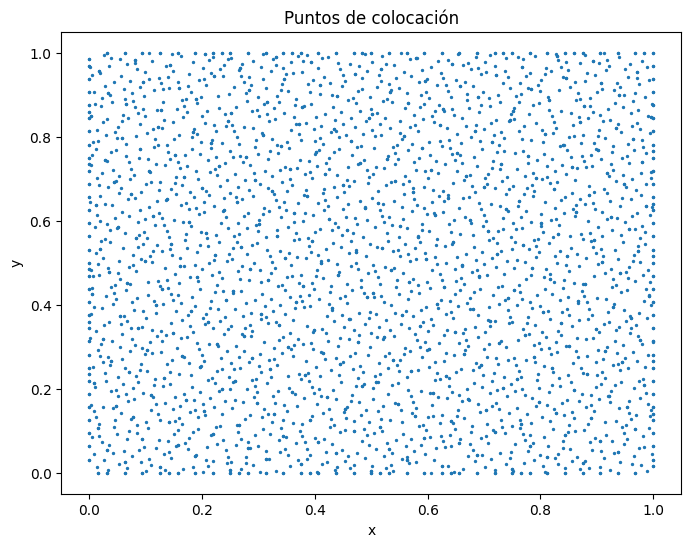

In [9]:
plots = Ploter((8,6)) # Construimos el objeto graficador para la barra
plots.collocation(data_placa, var="y") # Graficamos los puntos de colocación (train)

### **Entrenamiento**

In [10]:
pinn_placa = PINN(n_input=3, n_hidden=100, n_output=1, activation="tanh", mmm = "Glorot normal")
model1, losshistory1, train_state1 = pinn_placa.train_model(data_placa, steps=4000)

Compiling model...
Building feed-forward neural network...
'build' took 0.073252 s


'compile' took 0.634402 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.09e-02, 1.26e+00, 6.84e-01]    [2.05e-02, 1.26e+00, 6.84e-01]    []  
1000      [2.64e-03, 5.38e-02, 3.44e-01]    [1.93e-03, 5.38e-02, 3.44e-01]    []  
2000      [6.02e-03, 2.80e-02, 3.25e-01]    [3.24e-03, 2.80e-02, 3.25e-01]    []  
3000      [7.74e-03, 2.29e-02, 3.18e-01]    [3.81e-03, 2.29e-02, 3.18e-01]    []  
4000      [8.83e-03, 1.83e-02, 3.14e-01]    [3.19e-03, 1.83e-02, 3.14e-01]    []  

Best model at step 4000:
  train loss: 3.41e-01
  test loss: 3.35e-01
  test metric: []

'train' took 55.026402 s

Compiling model...
'compile' took 0.566188 s

Training model...

Step      Train loss                        Test loss                         Test metric
4000      [8.83e-03, 1.83e-02, 3.14e-01]    [3.19e-03, 1.83e-02, 3.14e-01]    []  

INFO:tens

## **Visualización de resultados**

Saving loss history to c:\Users\sebas\PINNs_UdeA\loss.dat ...
Saving training data to c:\Users\sebas\PINNs_UdeA\train.dat ...
Saving test data to c:\Users\sebas\PINNs_UdeA\test.dat ...


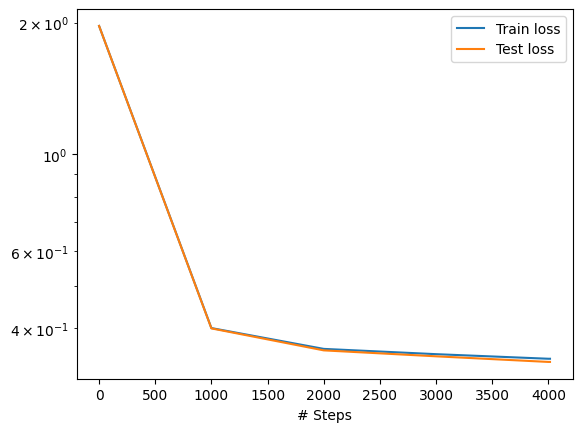

In [11]:
plots.train_plot(losshistory1, train_state1)

In [16]:
n=100
k = 0
grid = Makegrid(mode="3d")
grid_terms_placa = grid.grid_3D(n, k, params_placa, model1)

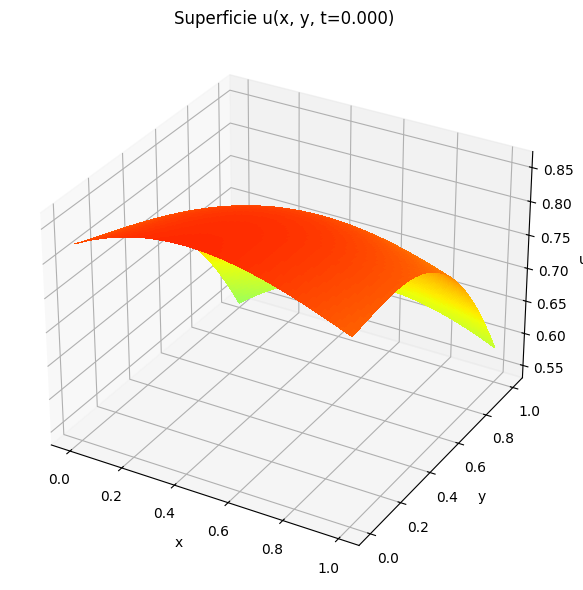

In [17]:
plots.surface_plot(grid_terms_placa, mode="placa")

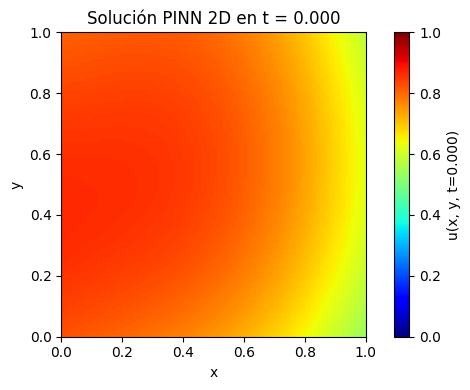

In [18]:
plots.heatmap_plot(grid_terms_placa, mode="placa")

## **Animación**

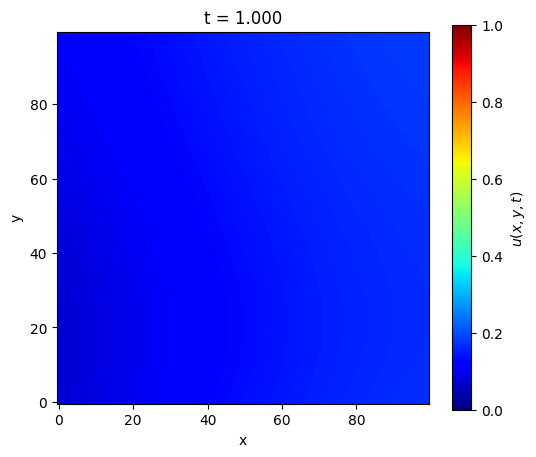

In [20]:
from moduleAnimation import animation_function_2d

anim = animation_function_2d(grid_terms_placa)